# 7장 앙상블 학습과 랜덤 포레스트

## 주요 내용

- 투표 기반 분류기
- 배깅/페이스팅
- 랜덤 패치/랜덤 서브스페이스
- 랜덤 포레스트
- 부스팅
- 스태킹

## 기본 설정

In [1]:
# 파이썬 ≥3.5 필수 (파이썬 3.7 추천)
import sys
assert sys.version_info >= (3, 5) 

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림 저장 위치 지정
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 7.1 다수결 분류기 (246쪽 또는 원서 p.189)

### 앙상블 학습 아이디어

앙상블 학습은 여러 대의 예측기의 결과를 수집하여 종합한 후에 예측값을 정하는 학습법이며,
앙상블 학습 알고리즘을 앙상블 기법이라 부른다.
성능이 약한 학습기 여러 대를 앙상블 학습에 이용하면 (보다) 강력한 학습기를 생성할 수 있다.
전제 조건은 다음과 같다.

- 학습기 사이의 독립성과 다양성이 보장되어야 한다.
- 충분히 많은 학습기가 사용되어야 한다.

#### 큰 수의 법칙

이에 대한 확률적 근거를 "51%의 확률로 앞면이 나오는 동전 1만 번 던지기"를 통해 설명할 수 있으며,
아래 코드가 모의실험을 실행한다.

- '동전 1만 번 던지기를 10번 실행'한 결과는 (1만, 10) 모양의 넘파이 어레이를
    무작위로 생성된 0과 1사이의 수를 이용하는 것으로 대신한다.
- 이어서 어레이의 각 항목을 0.51보다 작으면 True, 즉 앞면으로 간주한다.

In [2]:
# 앞면이 나올 확률
heads_proba = 0.51

# 동전 1만번 던지기를 10번 실행한 결과. 0.51보다 작으면 True, 즉 앞면으로 간주함.
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)

# 1만번 던질 때까지 각 단계에서 앞면이 나온 비율
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

아래 코드는 '1만 번 던지기'를 10번 실행할 때 앞면이 나올 확률이 모두 50% 이상의 값으로 수렴하는 사실을 보여준다.

Saving figure law_of_large_numbers_plot


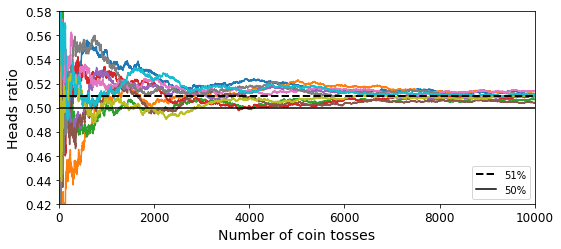

In [3]:
plt.figure(figsize=(8,3.5))

# 10번의 모의실험 결과 그래프
plt.plot(cumulative_heads_ratio)
# 51% 수렴선
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
# 50% 경계선
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")

plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
save_fig("law_of_large_numbers_plot")
plt.show()

위 모의실험은 
51% 정확도의 분류기를 충분히 많이 사용하면 양성/음성 예측에 대한 정확도가 매우 높아질 수 있다는 것을 보여준다.
물론 동전 던지기처럼 사용된 분류기들 사이의 독립성이 완벽하게 보장된다는 전제조건하에서만 그렇다. 
그렇지 않다면 예측기들 사이의 어떤 의존성으로 인해 성능이 보다 떨어질 수도 있다.

실제로 51%의 확률로 앞면이 나오는 동전을 1만 번 던졌을 때 앞면이 50% 이상 나올 학률은 97% 이상이며,
1천 번만 던져도 75% 정도로 앞면이 많이 나온다.
이를 51% 정확도의 분류기를 1만 번 또는 1천 번 실행해서 모은 예측값들 중에서 다수인 것을 선택하는 방식을 선택했을 때
각각 97% 이상과 75% 정도의 정확성을 갖는다는 것으로 이해할 수 있다.

언급된 확률은 수학적으로 이항분포를 이용하여 아래와 같이 간단하게 계산할 수 있다.
`ensemble_win_proba()` 함수는 정확도 p의 예측기 n개를 실행해서 다수결 원칙을 따랐을 때의 승률, 즉
다수결의 의견이 옳았을 확률을 계산한다.
이를 위해 이항분포의 누적밀도함수인 `binom.cdf()`를 이용한다.

__참고:__ `binom.cdf(x, n, p)` 함수는 
이항분포를 따르는 어떤 행위를 n번 시행할 때 확률 p의 사건이 x번 이하 발생할 확률을 계산하는 누적분포함수이다.
아래 코드에서는 50% 이상일 확률을 계산해야 하기에 x 대신에 50%보다 아주 조금 작은 빈도수를 입력하여
얻은 확률을 1에서 뺀다.

In [4]:
from scipy.stats import binom

def ensemble_win_proba(n, p):
    """
    p: 예측기 하나의 성능
    n: 앙상블 크기, 즉 예측기 개수
    반환값: 다수결을 따를 때 성공할 확률. 이항 분포의 누적분포함수 활용.
    """
    
    return 1 - binom.cdf(int(n*0.499999), n, p)

51%의 확률로 앞면이 나오는 동전을 1천 번 던져서 절반 이상 앞면이 나올 확률은 74.7%이다.

In [5]:
ensemble_win_proba(1000, 0.51)

0.7467502275561786

횟수를 1만 번으로 늘리면 확률이 97.7% 이상으로 나온다.
즉 1만 번 던지기를 100번하면 2번 정도만 5천 번 이하로 앞면이 나올 것으로 기대한다.

In [6]:
ensemble_win_proba(10000, 0.51)

0.9777976478701533

정확도 80% 정도의 이진분류기 10대를 이용한 앙상블 학습기의 성능이 99.3%까지 오를 수 있다.
매우 놀라운 결과이며, 실전에서 최적으로 튜닝된 모델의 성능을 앙상블 학습을 통해 개선하는 시도를 많이 한다.
물론 다시 한 번 말하지만 사용된 예측기의 다양성과 상호 독립성이 전제된 경우에 그럴 수 있다는 말이다.

In [7]:
ensemble_win_proba(10, 0.80)

0.9936306176

### 직접 투표 vs. 간접 투표

아래 코드는 여러 종류의 분류기를 앙상블로 묶어 훈련시키는 방법을 보여준다.
사용되는 훈련데이터는 moons 데이터셋이다.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

`VotingClassifier` 모델은 여러 개의 분류기를 이용한 앙상블 학습 분류기를 지원한다.
사용되는 분류기는 아래 세 개이다.

- 로지스틱 회귀
- 랜덤 포레스트 분류기
- 서포트 벡터 머신

#### 직접 투표

`voring='hard'`는 분류기들의 다수 예측값을 예측값으로 사용한다는 의미이다. 
이런 방식을 __직접 투표(hard voting)__라 한다.

In [9]:
from sklearn.ensemble import VotingClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], voting='hard')

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

앙상블 학습에 사용된 분류기 세 개에 비해 분류기의 정확도 성능이 보다 좋은 것을 아래 코드에서 확인할 수 있다.

In [10]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


#### 간접 투표

주어진 샘플의 클래스 확률을 계산하는 분류기들을 앙상블 학습에 사용하고
`voring='soft'`로 지정하면 분류기들의 클래스 확률의 평균값을 이용한다.
이런 방식을 __간접 투표(soft voting)__라 한다.

- 서포트 벡터 머신의 경우 `probability=True` 옵션을 지정해야 클래스 확률을 사용할 수 있다.

__참고:__ 클래스 확률은 `predict_proba()` 메서드가 계산한다.

In [11]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], voting='soft')

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

간접 투표 방식이 직접 투표 방식보다 정확도를 보다 높인다. 
하지만 기본값은 하지만 `voting=hard`, 즉 직접 투표이다.

In [12]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


## 7.2 배깅과 페이스팅 (249쪽 또는 원서 p.192)

### 7.2.1 사이킷런의 배깅과 페이스팅 (250쪽 또는 원서 p.194)

In [13]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [14]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [15]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


#### 그림 7-5 코드

In [16]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

Saving figure decision_tree_without_and_with_bagging_plot


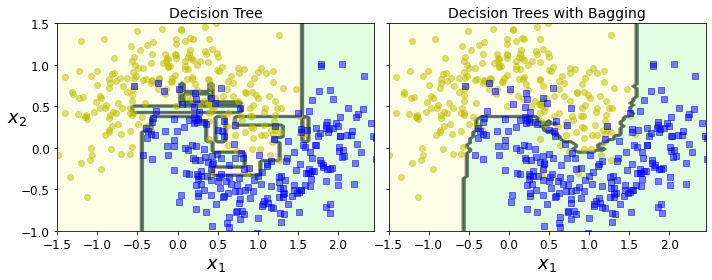

In [17]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

### 7.2.2 oob 평가 (252쪽 또는 원서 p.195)

In [18]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

In [19]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

처음 10개 훈련 샘플의 클래스 확률은 다음과 같다.

In [20]:
bag_clf.oob_decision_function_[:10]

array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.09497207, 0.90502793],
       [0.31147541, 0.68852459],
       [0.01754386, 0.98245614],
       [0.97109827, 0.02890173],
       [0.97765363, 0.02234637]])

## 7.4 랜덤 포레스트 (254쪽 또는 원서 p.197)

In [23]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, random_state=42)

In [24]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [25]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [26]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # almost identical predictions

0.976

아래 코드는 배깅이 작동하는 방식을 보여준다.

- 결정트리 모델을 독립적으로 15번 훈련
- `max_samples=1.0`, `bootstrap=True` 옵션 처럼 샘플 중복 선택 허용.
- 15개의 모델에 대해 결정경계를 희미하게 보여줌(참고: 배깅 모델의 경우 분류는 최빈값, 회귀는 평균값 사용).

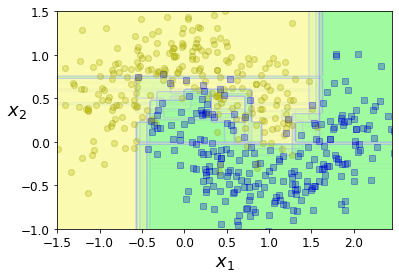

In [27]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.02, contour=False)

plt.show()

### 7.4.2 특성 중요도 (256쪽 또는 원서 p.198)

#### 붓꽃 특성 중요도

In [28]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [29]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

#### MNIST 이미지 특성 중요도

In [30]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [31]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(random_state=42)

In [32]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

Saving figure mnist_feature_importance_plot


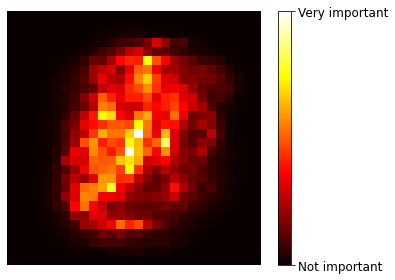

In [33]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()

## 7.5 부스팅 (257쪽 또는 원서 p.199)

### 7.5.1 에이다부스트 (258쪽 또는 원서 p.200)

#### 그림 7-8 코드

* moons 데이터셋에 rbf 커널을 사용하는 SVC 모델을 5번 연속으로 학습한 결과를 보여줌. 

Saving figure boosting_plot


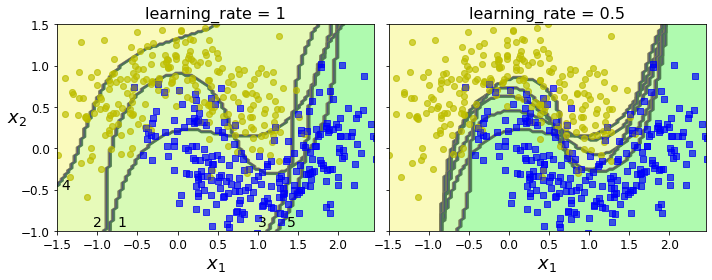

In [34]:
m = len(X_train)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)  # 업데이트된 샘플 가중치 사용
        y_pred = svm_clf.predict(X_train)

        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum() # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r) # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha) # equation 7-3
        sample_weights /= sample_weights.sum() # normalization step

        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=14)
        plt.text(-1.05, -0.95, "2", fontsize=14)
        plt.text(1.0, -0.95, "3", fontsize=14)
        plt.text(-1.45, -0.5, "4", fontsize=14)
        plt.text(1.36,  -0.95, "5", fontsize=14)
    else:
        plt.ylabel("")

save_fig("boosting_plot")
plt.show()

#### 사이킷런의 `AdaBoostClassifier` 모델 활용

`AdaBoostClassifier`의 기본 모델은 다음과 같다.

In [35]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)

moons 데이터셋에 훈련시킨 결과는 다음과 같다.

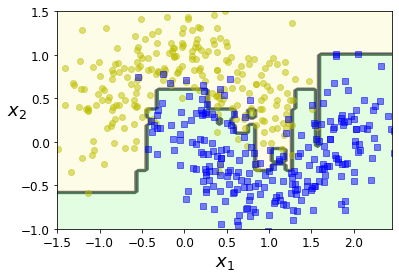

In [36]:
ada_clf.fit(X_train, y_train)

plot_decision_boundary(ada_clf, X, y)

### 7.5.2 그레이디언트 부스팅 (258쪽 또는 원서 p.203)

#### 그레이디언트 부스팅 작동 과정

아래 코드는 잡음이 섞인 2차 함수 그래프 형태의 훈련 세트를 사용하여
그레이디언트 부스팅 기법을 회귀 모델 훈련에 적용하는 것을 보여준다.

In [37]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

먼저, 결정트리 모델을 훈련시킨다. 

In [38]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

이어 잔여오차에 대해 다시 결정트리 모델을 훈련시킨다.

In [39]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

한번 더 잔여오차에 대해 다시 결정트리 모델을 훈련시킨다.

In [40]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

예측값은 사용된 예측기들의 예측값을 모두 더한 값이다.

In [41]:
X_new = np.array([[0.8]])

In [42]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

y_pred

array([0.75026781])

아래 함수는 회귀모델의 예측 성능을 그래프로 그린다.

In [43]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

아래 코드는 앞서 훈련시킨 세 개의 모델의 예측 성능을 그래프로 그린다.

- 좌변: 세 개의 예측기 각각의 예측 그래프
- 우변: 누적 예측 그래프

Saving figure gradient_boosting_plot


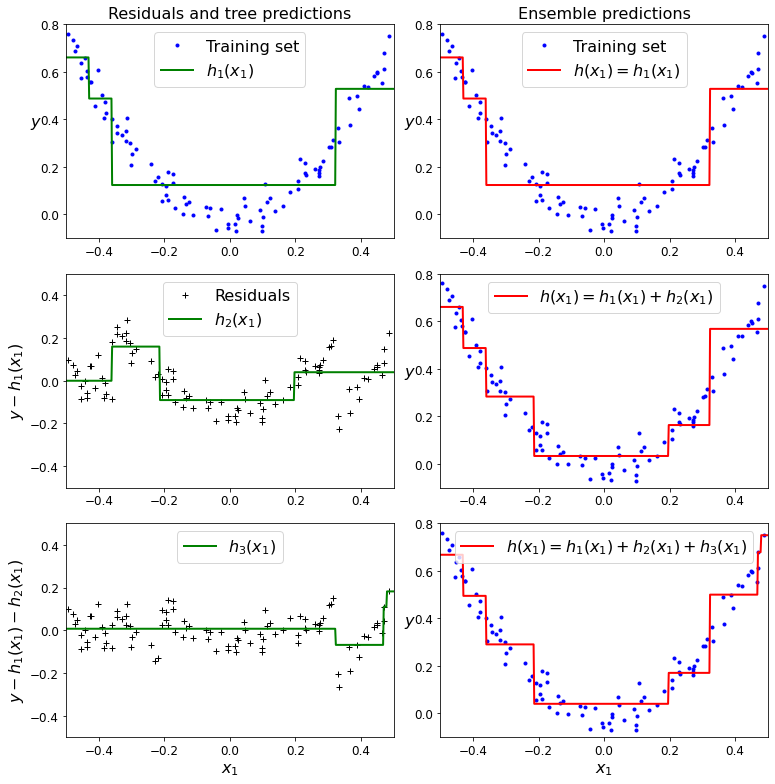

In [44]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

#### 사이킷런의 GBRT 모델 활용

하이퍼파라미터가 다른 2 개의 `GradientBoostingRegressor` 모델의 성능 차이를 살펴본다.

* `learning_rate=1.0`: 큰 학습률
* `n_estimators=3`: 세 개의 예측기만 사용. 즉, 두 번의 잔여오차 예측 모델 훈련 실행

In [45]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

* `learning_rate=0.1`: 작은 학습률
* `n_estimators=200`: 200 개의 예측기만 사용. 즉, 199 번의 잔여오차 예측 모델 훈련 실행

In [46]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

아래 코드는 위 두 개의 다른 두 GBRT 모델의 성능을 그래프로 그린다.

- 좌변: 큰 학습률, 3 개의 예측기
- 우변: 작은 학습률, 200개의 예측기

Saving figure gbrt_learning_rate_plot


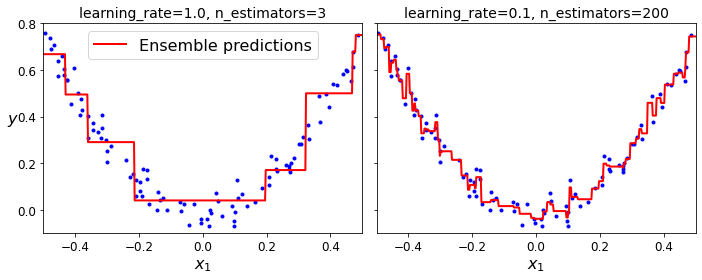

In [47]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

# 좌변 그래프
plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

# 우변 그래프
plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

save_fig("gbrt_learning_rate_plot")
plt.show()

#### 조기종료를 사용하는 그레이디언트 부스팅

In [48]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

In [49]:
min_error = np.min(errors)

Saving figure early_stopping_gbrt_plot


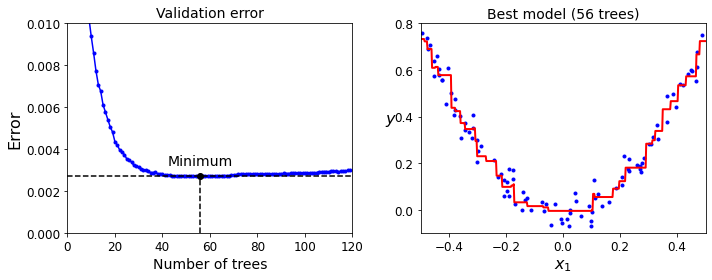

In [50]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

save_fig("early_stopping_gbrt_plot")
plt.show()

In [51]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [52]:
print(gbrt.n_estimators)

61


In [53]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


#### XGBoost 사용하기

In [54]:
try:
    import xgboost
except ImportError as ex:
    print("Error: the xgboost library is not installed.")
    xgboost = None

Error: the xgboost library is not installed.


In [55]:
if xgboost is not None:  # not shown in the book
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred) # Not shown
    print("Validation MSE:", val_error)           # Not shown

In [56]:
if xgboost is not None:  # not shown in the book
    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)], early_stopping_rounds=2)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)  # Not shown
    print("Validation MSE:", val_error)            # Not shown

In [57]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None

38.9 ns ± 0.375 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [58]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

15.6 ms ± 459 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Exercise solutions

## 1. to 7.

See Appendix A.

## 8. Voting Classifier

Exercise: _Load the MNIST data and split it into a training set, a validation set, and a test set (e.g., use 50,000 instances for training, 10,000 for validation, and 10,000 for testing)._

The MNIST dataset was loaded earlier.

In [59]:
from sklearn.model_selection import train_test_split

In [60]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    mnist.data, mnist.target, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=42)

Exercise: _Then train various classifiers, such as a Random Forest classifier, an Extra-Trees classifier, and an SVM._

In [61]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

In [62]:
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
svm_clf = LinearSVC(max_iter=100, tol=20, random_state=42)
mlp_clf = MLPClassifier(random_state=42)

In [63]:
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)

Training the RandomForestClassifier(random_state=42)
Training the ExtraTreesClassifier(random_state=42)
Training the LinearSVC(max_iter=100, random_state=42, tol=20)
Training the MLPClassifier(random_state=42)


In [64]:
[estimator.score(X_val, y_val) for estimator in estimators]

[0.9692, 0.9715, 0.859, 0.9635]

The linear SVM is far outperformed by the other classifiers. However, let's keep it for now since it may improve the voting classifier's performance.

Exercise: _Next, try to combine them into an ensemble that outperforms them all on the validation set, using a soft or hard voting classifier._

In [65]:
from sklearn.ensemble import VotingClassifier

In [66]:
named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf),
]

In [67]:
voting_clf = VotingClassifier(named_estimators)

In [68]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf',
                              LinearSVC(max_iter=100, random_state=42, tol=20)),
                             ('mlp_clf', MLPClassifier(random_state=42))])

In [69]:
voting_clf.score(X_val, y_val)

0.9703

In [70]:
[estimator.score(X_val, y_val) for estimator in voting_clf.estimators_]

[0.9692, 0.9715, 0.859, 0.9635]

Let's remove the SVM to see if performance improves. It is possible to remove an estimator by setting it to `None` using `set_params()` like this:

In [71]:
voting_clf.set_params(svm_clf=None)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf', None),
                             ('mlp_clf', MLPClassifier(random_state=42))])

This updated the list of estimators:

In [72]:
voting_clf.estimators

[('random_forest_clf', RandomForestClassifier(random_state=42)),
 ('extra_trees_clf', ExtraTreesClassifier(random_state=42)),
 ('svm_clf', None),
 ('mlp_clf', MLPClassifier(random_state=42))]

However, it did not update the list of _trained_ estimators:

In [73]:
voting_clf.estimators_

[RandomForestClassifier(random_state=42),
 ExtraTreesClassifier(random_state=42),
 LinearSVC(max_iter=100, random_state=42, tol=20),
 MLPClassifier(random_state=42)]

So we can either fit the `VotingClassifier` again, or just remove the SVM from the list of trained estimators:

In [74]:
del voting_clf.estimators_[2]

Now let's evaluate the `VotingClassifier` again:

In [75]:
voting_clf.score(X_val, y_val)

0.9737

A bit better! The SVM was hurting performance. Now let's try using a soft voting classifier. We do not actually need to retrain the classifier, we can just set `voting` to `"soft"`:

In [76]:
voting_clf.voting = "soft"

In [77]:
voting_clf.score(X_val, y_val)

0.9695

Nope, hard voting wins in this case.

_Once you have found one, try it on the test set. How much better does it perform compared to the individual classifiers?_

In [78]:
voting_clf.voting = "hard"
voting_clf.score(X_test, y_test)

0.9701

In [79]:
[estimator.score(X_test, y_test) for estimator in voting_clf.estimators_]

[0.9645, 0.9691, 0.9595]

The voting classifier only very slightly reduced the error rate of the best model in this case.

## 9. Stacking Ensemble

Exercise: _Run the individual classifiers from the previous exercise to make predictions on the validation set, and create a new training set with the resulting predictions: each training instance is a vector containing the set of predictions from all your classifiers for an image, and the target is the image's class. Train a classifier on this new training set._

In [80]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)

In [81]:
X_val_predictions

array([[5., 5., 5., 5.],
       [8., 8., 8., 8.],
       [2., 2., 3., 2.],
       ...,
       [7., 7., 7., 7.],
       [6., 6., 6., 6.],
       [7., 7., 7., 7.]], dtype=float32)

In [82]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
rnd_forest_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)

In [83]:
rnd_forest_blender.oob_score_

0.9693

You could fine-tune this blender or try other types of blenders (e.g., an `MLPClassifier`), then select the best one using cross-validation, as always.

Exercise: _Congratulations, you have just trained a blender, and together with the classifiers they form a stacking ensemble! Now let's evaluate the ensemble on the test set. For each image in the test set, make predictions with all your classifiers, then feed the predictions to the blender to get the ensemble's predictions. How does it compare to the voting classifier you trained earlier?_

In [84]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [85]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [86]:
from sklearn.metrics import accuracy_score

In [87]:
accuracy_score(y_test, y_pred)

0.9667

This stacking ensemble does not perform as well as the voting classifier we trained earlier, it's not quite as good as the best individual classifier.